<a href="https://colab.research.google.com/github/GerardoFesta/3DFER_SE4AI/blob/main/models/2DModels/2DCnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount("/content/drive")
import zipfile


Mounted at /content/drive


In [2]:
zip_ref = zipfile.ZipFile('drive/Shareddrives/Datasets SEFAI/fer2013.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall() #Extracts the files into the /tmp folder
zip_ref.close()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Questo commento serve per provare il funzionamento dei commit con colab

# **Dataset Loading**

In [5]:
train_dir = "train" # Directory containing the training data
test_dir = "test"  # Directory containing the validation data

# Define the transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),

])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = ImageFolder(train_dir, transform=train_transform)
test_dataset = ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# **Rete convolutiva**

In [68]:
def accuracy(preds, labels):
  probabilities = torch.nn.functional.softmax(preds, dim=1)
  _, predicted = torch.max(probabilities, 1)
  n_correct = (predicted==labels).sum().float()

  acc =n_correct / labels.shape[0]
  acc= torch.round(acc*100)
  return acc, n_correct;


In [72]:

class CNN(nn.Module):
    def __init__(self):

        super(CNN, self).__init__()


        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.relu5 = nn.ReLU()

        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.relu6 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(256 * 6 * 6, 256)

        self.bn7 = nn.BatchNorm1d(256)
        self.relu7 = nn.ReLU()

        self.dropout4 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 7)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.pool1(x)

        x = self.dropout1(x)
        #print("dropout1 ", x.shape)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        #print("conv4 ", x.shape)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.pool2(x)

        x = self.dropout2(x)


        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)

        x = self.conv6(x)
        #print("conv6 ", x.shape)
        x = self.bn6(x)
        x = self.relu6(x)

        x = self.pool3(x)
        x = self.dropout3(x)
        #print("dropout3 ", x.shape)
        x = x.view(-1, 256 * 6 * 6)
        #print(x.shape)
        x = self.fc1(x)
        x = self.bn7(x)
        x = self.relu7(x)
        x = self.dropout4(x)
        x = self.fc2(x)
        return x



In [73]:
model = CNN()

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

model.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=

In [74]:
acc_list_train=[]
acc_list_test=[]
num_epochs = 100
best_loss = 1000
patience=3
counter = 0
stop = False

# Training loop
best_accuracy = 0.0

for epoch in range(num_epochs):
    print(counter)
    if stop:
      print(stop)
      break
    model.train()
    running_loss = 0.0
    total_correct = 0
    seen = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, acc = accuracy(outputs, labels)
        total_correct += acc
        seen +=labels.shape[0]
        running_loss += loss.item()

    train_accuracy = total_correct / seen
    train_loss = running_loss / len(train_loader)
    print (f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Acc: {total_correct/seen:.4f}')

    model.eval()
    total_correct = 0
    seen = 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, acc = accuracy(outputs, labels)
            total_correct += acc
            seen +=labels.shape[0]

    test_accuracy = total_correct / seen
    test_loss = running_loss / len(test_loader)
    print("Test acc: ", test_accuracy)
    print("Test loss: ", test_loss)

    if test_loss < best_loss:
          print("MIGLIORATO")
          torch.save(model.state_dict(), 'model_weights.pth')
          best_loss = test_loss
          best_model_train_acc=train_accuracy
          best_model_test_acc=test_accuracy
          best_model_test_loss=test_loss
          best_model_train_loss=running_loss / len(train_loader)
          counter = 0
          # Salva i pesi del modello se la validation loss è migliorata
          torch.save(model.state_dict(), 'best_model.pt')
    else:
        counter += 1
        # Verifica se raggiunto il criterio di early stopping
        if counter >= patience:
              print(f'Early stopping at epoch {epoch+1}')
              stop=True
    print("BEST TEST LOSS: ", best_loss)

    print(f"Epoch {epoch+1}/{50}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


0
Epoch [0/100], Loss: 1.7808, Acc: 0.2945
Test acc:  tensor(0.3643, device='cuda:0')
Test loss:  1.6546207740243557
MIGLIORATO
BEST TEST LOSS:  1.6546207740243557
Epoch 1/50, Train Loss: 1.7808, Train Accuracy: 0.2945, Test Accuracy: 0.3643, Test Loss: 1.6546
0
Epoch [1/100], Loss: 1.5593, Acc: 0.3930
Test acc:  tensor(0.4505, device='cuda:0')
Test loss:  1.4296913605875674
MIGLIORATO
BEST TEST LOSS:  1.4296913605875674
Epoch 2/50, Train Loss: 1.5593, Train Accuracy: 0.3930, Test Accuracy: 0.4505, Test Loss: 1.4297
0
Epoch [2/100], Loss: 1.4465, Acc: 0.4446
Test acc:  tensor(0.4694, device='cuda:0')
Test loss:  1.3858080664567187
MIGLIORATO
BEST TEST LOSS:  1.3858080664567187
Epoch 3/50, Train Loss: 1.4465, Train Accuracy: 0.4446, Test Accuracy: 0.4694, Test Loss: 1.3858
0
Epoch [3/100], Loss: 1.3787, Acc: 0.4695
Test acc:  tensor(0.5128, device='cuda:0')
Test loss:  1.2827130107753044
MIGLIORATO
BEST TEST LOSS:  1.2827130107753044
Epoch 4/50, Train Loss: 1.3787, Train Accuracy: 0.469

In [76]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, classification_report

model = CNN()
model.load_state_dict(torch.load("model_weights.pth"))
model.eval()
model.to(device)



# Calcola le metriche sul test dataset
model.eval()  # Imposta il modello in modalità di valutazione (non addestramento)
test_predictions = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
        test_predictions.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average=None)
f1 = f1_score(test_labels, test_predictions, average=None)
#auc_roc = roc_auc_score(test_labels, test_predictions, multi_class='ovr')
classification_rep = classification_report(test_labels, test_predictions)

print("Test Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
#print("AUC-ROC:", auc_roc)
print("Classification Report:\n", classification_rep)

Test Metrics:
Accuracy: 0.6014210086375035
Precision: [0.5019305  0.73469388 0.43829787 0.77926078 0.5499232  0.47184774
 0.71037628]
F1 Score: [0.52156469 0.45       0.35743204 0.81569049 0.56489152 0.47448166
 0.7295082 ]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.54      0.52       958
           1       0.73      0.32      0.45       111
           2       0.44      0.30      0.36      1024
           3       0.78      0.86      0.82      1774
           4       0.55      0.58      0.56      1233
           5       0.47      0.48      0.47      1247
           6       0.71      0.75      0.73       831

    accuracy                           0.60      7178
   macro avg       0.60      0.55      0.56      7178
weighted avg       0.59      0.60      0.59      7178



In [ ]:
!pip install grad-cam

In [132]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model.conv6]
input_image_path = '/content/test/happy/PrivateTest_10077120.jpg'
input_image = Image.open(input_image_path)
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


input_tensor = transform(input_image).unsqueeze(0)

immagine =cv2.imread('/content/test/happy/PrivateTest_10077120.jpg')
# Normalizzazione dell'immagine di input
input_image = immagine.astype(np.float32) / 255.0


# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(6)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(input_image, grayscale_cam, use_rgb=True)

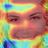

In [133]:
from google.colab.patches import cv2_imshow
cv2_imshow(visualization)